
## NIO

* gradient based input optimization from constrained outputs 

## Web application (NOT deployed yet)

Run interactively on the web at: 




## Inputs

(2, 'i_h2i_rate')

(3, 'i_pci_rate')

(5, 'i_ngi_rate')

(6, 'i_o2_volfract')

(8, 'i_h2_temp')

(9, 'i_hbtemp')

(10, 'i_wind_rt')


## Outputs


* desired output requirements 



Top gas temp > 100C,,,,,,,,,,,(27, 'o_tgt')

 
Hot metal temp > 1700K........(29, 'o_hmt')


Raceway flame temp > 1900K.....(40, 'o_fta')









## Installs


In [1]:

## !pip install xgboost
## !pip install onnxmltools
## !pip install onnxruntime



## Imports


In [2]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)




In [4]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt



In [5]:

import PDFshapingUtils as PDF_tk



## Instantiate PDF shaping and regression class


In [6]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [7]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5       ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [8]:

PDFshapingOBJ.initializeImpulseGaussian()



## Load Data


In [9]:

## PDFshapingOBJ.read_csv_file_with_pandas('energy_regression_dataset.csv')

PDFshapingOBJ.read_csv_file_with_pandas('CFD.16.2025.csv')


In [10]:

PDFshapingOBJ.CFD_raw_data


,index,case name,i_h2i_rate,i_pci_rate,i_wpi_rate,i_ngi_rate,i_o2_volfract,i_ng_temp,i_h2_temp,i_hbtemp,...,o_h2o_sollos,o_feo_sollos,o_hm_rt,o_mw_rt,o_wf_rt,o_hm_h2share,o_mw_h2share,o_wf_h2share,o_prod_rt,o_fta
0,1,H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HB...,0,0,0,120,21,300,0,1200,...,20.0,44.9,122.0,264.0,687.0,31.6,26.7,63.5,4050.0,1800.0
1,2,H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...,0,0,0,100,21,300,0,1200,...,18.5,52.6,122.0,265.0,684.0,27.9,23.4,60.6,4060.0,1850.0
2,3,H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...,0,0,0,100,21,300,0,1200,...,19.6,50.9,123.0,266.0,690.0,27.7,23.5,60.8,4080.0,1850.0
3,4,H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...,0,0,0,100,21,300,0,1200,...,19.2,52.2,124.0,268.0,690.0,27.7,23.2,60.6,4090.0,1850.0
4,5,H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...,0,0,0,100,21,300,0,1200,...,19.2,52.4,124.0,268.0,695.0,27.7,23.2,60.7,4110.0,1850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4995,H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...,30,0,0,80,30,300,300,1600,...,18.7,40.3,353.0,763.0,2190.0,34.0,20.5,56.7,11700.0,2380.0
4995,4996,H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...,30,0,0,80,30,300,300,1480,...,18.7,40.7,353.0,763.0,2190.0,33.8,20.4,56.8,11700.0,2310.0
4996,4997,H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...,30,0,0,80,30,300,300,1600,...,19.2,37.5,353.0,763.0,2230.0,33.6,20.4,57.1,11700.0,2380.0
4997,4998,H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_...,30,0,0,80,30,300,300,1480,...,17.6,39.8,355.0,768.0,2220.0,34.0,20.0,55.7,11800.0,2310.0


In [11]:

PDFshapingOBJ.print_headers_list()


['index', 'case name', 'i_h2i_rate', 'i_pci_rate', 'i_wpi_rate', 'i_ngi_rate', 'i_o2_volfract', 'i_ng_temp', 'i_h2_temp', 'i_hbtemp', 'i_wind_rt', 'i_blastH2O', 'i_BdnH2O', 'i_sgi_rate', 'i_sgtemp', 'i_sgi_H2COratio', 'i_sgi_ReProRatio', 'o_tuy_velo', 'o_tuy_temp', 'o_burn', 'o_delp', 'o_co_vf', 'o_co2_vf', 'o_h2_vf', 'o_n2_vf', 'o_co_util', 'o_h2_util', 'o_tgt', 'o_coke_rt', 'o_hmt', 'o_co2_sollos', 'o_h2o_sollos', 'o_feo_sollos', 'o_hm_rt', 'o_mw_rt', 'o_wf_rt', 'o_hm_h2share', 'o_mw_h2share', 'o_wf_h2share', 'o_prod_rt', 'o_fta']
41
(0, 'index')
(1, 'case name')
(2, 'i_h2i_rate')
(3, 'i_pci_rate')
(4, 'i_wpi_rate')
(5, 'i_ngi_rate')
(6, 'i_o2_volfract')
(7, 'i_ng_temp')
(8, 'i_h2_temp')
(9, 'i_hbtemp')
(10, 'i_wind_rt')
(11, 'i_blastH2O')
(12, 'i_BdnH2O')
(13, 'i_sgi_rate')
(14, 'i_sgtemp')
(15, 'i_sgi_H2COratio')
(16, 'i_sgi_ReProRatio')
(17, 'o_tuy_velo')
(18, 'o_tuy_temp')
(19, 'o_burn')
(20, 'o_delp')
(21, 'o_co_vf')
(22, 'o_co2_vf')
(23, 'o_h2_vf')
(24, 'o_n2_vf')
(25, 'o_co_ut

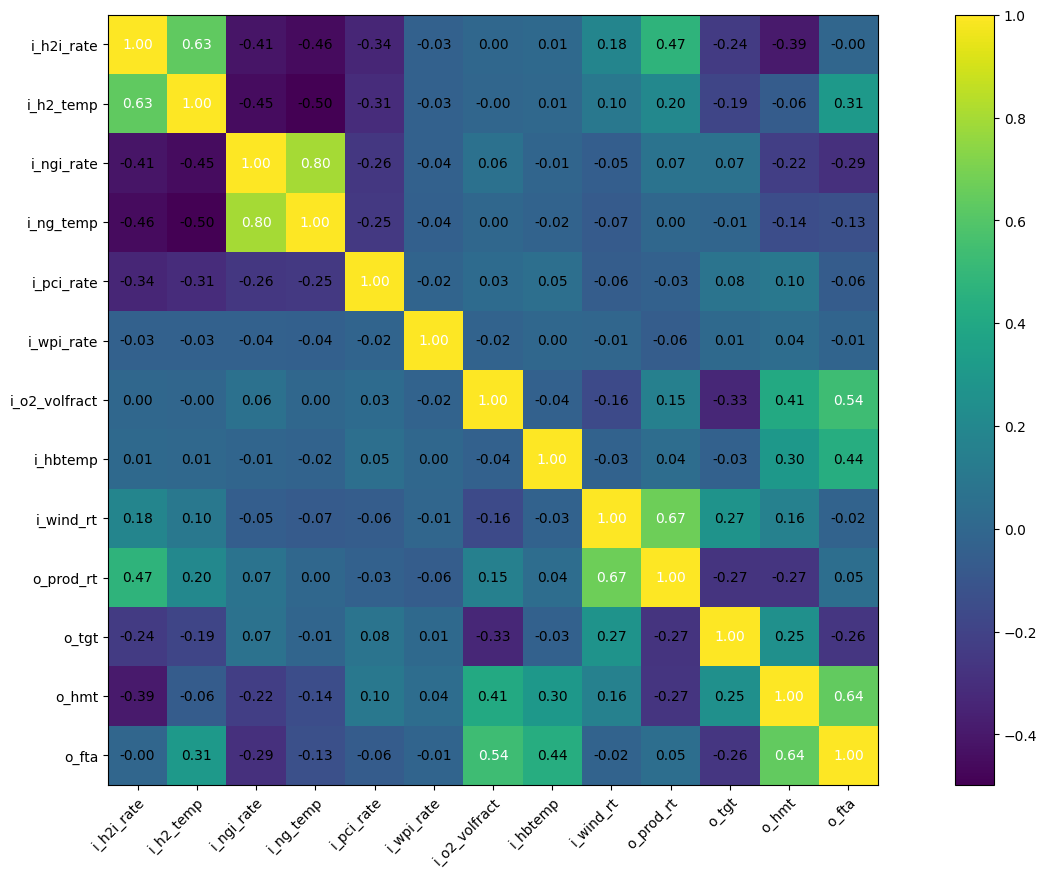

In [12]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2i_rate','i_h2_temp','i_ngi_rate','i_ng_temp','i_pci_rate',
                    'i_wpi_rate','i_o2_volfract',
                    'i_hbtemp','i_wind_rt','o_prod_rt', 'o_tgt', 'o_hmt','o_fta']



PDFshapingOBJ.print_correlation_coefficients()


In [13]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[1
  'H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HBT-1200_WR-195_MHB-5.7_BM-7_SGI-0_SGT-0_SGC_0 '
  0 ... 63.5 4050.0 1800.0]
 [2
  'H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HBT-1200_WR-195_MHB-5.7_BM-1_SGI-0_SGT-0_SGC_0 '
  0 ... 60.6 4060.0 1850.0]
 [3
  'H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HBT-1200_WR-195_MHB-5.7_BM-5_SGI-0_SGT-0_SGC_0 '
  0 ... 60.8 4080.0 1850.0]
 ...
 [4997
  'H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_HBT-1600_WR-230_MHB-5.7_BM-5_SGI-0_SGT-0_SGC_0 '
  30 ... 57.1 11700.0 2380.0]
 [4998
  'H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_HBT-1480_WR-230_MHB-5.7_BM-3_SGI-0_SGT-0_SGC_0 '
  30 ... 55.7 11800.0 2310.0]
 [4999
  'H2-30_PCI-0_WPI-0_NG-80_O2-30_NGT-300_H2T-300_HBT-1480_WR-230_MHB-5.7_BM-5_SGI-0_SGT-0_SGC_0 '
  30 ... 56.2 11800.0 2310.0]]
(4999, 41)



## Select inputs and outputs


In [14]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 2, 3, 5, 6, 8, 9, 10 ] , 
                   outputs= [ 27, 29, 40 ]   
)




7
3


In [15]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(4999, 7)
(4999, 3)


In [16]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [17]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(3999, 7)
(1000, 7)
(3999, 3)
(1000, 3)


In [18]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [19]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [20]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


In [21]:

n_inputs  = 7
n_outputs = 3


class SimpleNet(nn.Module):
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_outputs)
        )
        
    def forward(self, x):
        x          = (x - self.x_means) / self.x_deviations
        y_scaled   = self.model(x)
        ## y_scaled   = torch.tanh(y_scaled)   
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    
   
    
        


In [22]:

n_inputs  = 7
n_outputs = 3

class ResidualNet(nn.Module):
    def __init__(self, x_means, x_deviations, y_means, y_deviations, dropout_rate=0.1):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
     
        self.fc1  = nn.Linear(n_inputs, 64)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(64, 64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, n_outputs)

        # If input_dim ≠ 64, project for residual addition
        self.input_proj = nn.Linear(n_inputs, 64) if n_inputs != 64 else nn.Identity()

    def forward(self, x):
        x          = (x - self.x_means) / self.x_deviations
        x0 = self.input_proj(x)
        x1 = self.dropout1(self.act1(self.fc1(x)))
        x2 = self.dropout2(self.act2(self.fc2(x1)))
        x_res = x2 + x0
        y_scaled = self.fc3(x_res)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled


In [23]:


model     = ResidualNet(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.MSELoss()


In [24]:

model.train()

for epoch in range(1000):
    for xb, yb in PDFshapingOBJ.train_dl:
        optimizer.zero_grad()
        
        pred_descaled, pred_scaled = model(xb)
        
        loss = loss_fn(pred_scaled, yb)
        
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        print(epoch, ".....", loss.item() ) 
    
    

0 ..... 0.3009168803691864
100 ..... 0.24315395951271057
200 ..... 0.15502195060253143
300 ..... 0.18393151462078094
400 ..... 0.09674546867609024
500 ..... 0.42974022030830383
600 ..... 0.14034613966941833
700 ..... 0.13210448622703552
800 ..... 0.20774900913238525
900 ..... 0.12801571190357208


In [25]:

print("=== SANITY CHECK: SCALING ===")
print("y_means:", PDFshapingOBJ.y_means)
print("y_deviations:", PDFshapingOBJ.y_deviations)

print("===============================================")

print("x_means:", PDFshapingOBJ.x_means)
print("x_deviations:", PDFshapingOBJ.x_deviations)

'''
model.eval()
with torch.no_grad():
    test_input = get_x_from_z(z)
    y_descaled, y_scaled = model(test_input)

    print("x_guess:", test_input)
    print("y_scaled (standardized):", y_scaled)
    print("y_descaled (real units):", y_descaled)
'''


=== SANITY CHECK: SCALING ===
y_means: tensor([[  97.4813, 1298.5353, 2308.0481]])
y_deviations: tensor([[ 50.2664, 525.0270, 210.3159]])
x_means: tensor([[  12.5306,   18.9647,   41.1788,   25.6069,  268.9422, 1440.8802,
          198.6672]])
x_deviations: tensor([[ 15.3287,  45.7489,  46.6067,   3.3204, 360.9375, 157.9338,  26.5069]])


'\nmodel.eval()\nwith torch.no_grad():\n    test_input = get_x_from_z(z)\n    y_descaled, y_scaled = model(test_input)\n\n    print("x_guess:", test_input)\n    print("y_scaled (standardized):", y_scaled)\n    print("y_descaled (real units):", y_descaled)\n'


## Step 2: NIO



## Utility Functions

* some of the utility functions



## Initialize Z


In [26]:

z_init = torch.rand((1, 7)) * 0.4 + 0.3              # middle of sigmoid range
z      = torch.nn.Parameter( torch.logit(z_init) )

print( z )


Parameter containing:
tensor([[-0.0428, -0.6273,  0.6280, -0.2012,  0.3376,  0.0092,  0.3631]],
       requires_grad=True)



## Regularize the z vector

* here you square every value and sum like in MSE
* useful way to get a metric for the vector that we may want to minimize or maximize


In [27]:

def regularize_z(z, strength=1e-3):
    
    return strength * torch.sum(z**2)


In [28]:

regularize_z(  z  )


tensor(0.0011, grad_fn=<MulBackward0>)


## Get x from z lambda function 

* ensure the x generated from the z is within the clamps 


In [29]:

get_x_from_z = lambda z: clamp_min + (clamp_max - clamp_min) * torch.sigmoid(z)



In [30]:

clamp_min = torch.tensor([[  0,   0,   0,    21,   0,   1300, 150 ]])     ## from Ty
clamp_max = torch.tensor([[  0, 200, 200,    32,   0,   1500, 250 ]])


In [31]:

x_guess_temp = get_x_from_z(z)
x_guess_temp


tensor([[   0.0000,   69.6233,  130.4062,   25.9486,    0.0000, 1400.4613,
          208.9799]], grad_fn=<AddBackward0>)


## Soft penalty box for loss 


In [32]:

def soft_box_penalty(x, lower, upper, strength=10.0):
    
    return strength * ((torch.relu(lower - x) ** 2).sum() + (torch.relu(x - upper) ** 2).sum())



In [33]:

soft_box_penalty(x_guess_temp, clamp_min, clamp_max, strength=10.0)


tensor(0., grad_fn=<MulBackward0>)


## Inputs

*  x_guess = torch.tensor([[20, 600, 10, 250, 0.35, 1300, 200]], requires_grad=True)




In [34]:




z_init = torch.rand((1, 7)) * 0.4 + 0.3              # middle of sigmoid range
z      = torch.nn.Parameter( torch.logit(z_init) )


optimizer_infer = torch.optim.Adam([z], lr=0.03)     ## 0.05


scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer_infer, step_size=40000, gamma=0.5
)



print( z.shape )
print( z ) 


torch.Size([1, 7])
Parameter containing:
tensor([[ 0.7502,  0.5228,  0.6401,  0.2087,  0.3315, -0.0731, -0.6059]],
       requires_grad=True)



## Outputs



desired output requirements

Raceway flame temp > 1900K.....(17, 'o_fta')

Hot metal temp > 1700K.........(21, 'o_hmt')

Top gas temp > 100C............(23, 'o_tgt')




In [35]:

## target_output_not_scaled   = torch.tensor([[1900.0, 1700.0, 100.0    ]])  # initial per Ty
## target_output_not_scaled   = torch.tensor([[3100.0, 1850.0, 125.0    ]])  # slightly above model  ## remove 


In [36]:


'''

Top gas temp > 100C,,,,,,,,,,,(27, 'o_tgt')
Hot metal temp > 1700K........(29, 'o_hmt')
Raceway flame temp > 1900K.....(40, 'o_fta')


'''

                                      
target_output_not_scaled   = torch.tensor([[70., 1800., 2600.]])

margin_out                  = torch.tensor([[1e6, 1e6, 200.0]])   ## 1e6 = 1 million


#######################################################################################

lower_bounds_glob    = target_output_not_scaled.clone()                          
upper_bounds_glob    = target_output_not_scaled  + margin_out

print( lower_bounds_glob  )
print( upper_bounds_glob  )

#######################################################################################

lower_bounds_glob    = ( lower_bounds_glob - PDFshapingOBJ.y_means) / PDFshapingOBJ.y_deviations
upper_bounds_glob    = ( upper_bounds_glob - PDFshapingOBJ.y_means) / PDFshapingOBJ.y_deviations

#######################################################################################


target_output   = ( target_output_not_scaled - PDFshapingOBJ.y_means) / PDFshapingOBJ.y_deviations




tensor([[  70., 1800., 2600.]])
tensor([[1000070., 1001800.,    2800.]])



## Parameters


In [37]:

## constraint_mask = torch.tensor([  2,     2,      2   ])   # 2 = ≥, 0 = no constraint

## constraint_weights = torch.tensor([3.0, 8.0, 4.0])            # Penalize all more
## constraint_weights = torch.tensor([3.0, 16.0, 8.0])  # was [3.0, 8.0, 4.0]
## constraint_weights = torch.tensor([1.0, 5.0, 1.0])         # Heavier weight on hot metal temp

## overshoot_margin   = torch.tensor([200.0, 50.0, 20.0])  # Limits o_fta to ≤ 2100
## overshoot_margin   = torch.tensor([100.0, 50.0, 10.0])       # Tighter!
## overshoot_margin   = torch.tensor([500.0, 100.0, 50.0])    # Tolerable overshoot per output
## overshoot_margin   = torch.tensor([100.0, 100.0, 50.0])    # Tolerable overshoot per output



In [38]:



constraint_mask = torch.tensor([  2,     2,      3  ])  # o_fta is now “within range”


print( constraint_mask )


overshoot_margin     = torch.tensor([10.0, 30.0, 100.0])  


constraint_weights   = torch.tensor([1.0, 3.0, 1.0])

alpha = 0.9     




tensor([2, 2, 3])


In [39]:




def constraint_loss(y_pred, y_target, mask, overshoot_margin, weights, reg_weight=1e-4):
    
    loss = 0.0
    
    for i in range( y_pred.shape[1] ):
        
        weight = weights[i]
        if mask[i] == 1:  # equality constraint
            
            loss = loss + weight * (   y_pred[0, i] - y_target[0, i]   )**2

        elif mask[i] == 2:  # ≥ constraint
            # Penalize undershoot 
            loss = loss + weight * torch.relu(  y_target[0, i] - y_pred[0, i]  )**2
            # Penalize excessive overshoot
            safe_upper = y_target[0, i] + overshoot_margin[i]
            loss = loss + weight * torch.relu(  y_pred[0, i] - safe_upper  )**2

        elif mask[i] == 3:  # bounded range
            a = lower_bounds_glob[0, i]
            b = upper_bounds_glob[0, i]
            loss = loss + weight * torch.relu(a - y_pred[0, i])**2
            loss = loss + weight * torch.relu(y_pred[0, i] - b)**2

    # Regularization on output predictions
    loss = loss + reg_weight * torch.sum(y_pred**2)
    return loss






In [40]:

'''

Inputs

(2, 'i_h2i_rate'):  0 to 100
(3, 'i_h2_temp'):   0 to 1500 
(4, 'i_ngi_rate'):  0 to 300
(6, 'i_pci_rate'):  0 to 300
(11, 'i_o2_volfract'): 21 to 40
(12, 'i_hbtemp'): 1200 to 1500
(13, 'i_wind_rt'): 150 to 250


other inputs:

(2, 'i_h2i_rate'):  0
(3, 'i_h2_temp'):   0
(4, 'i_ngi_rate'): 0 to 200
(6, 'i_pci_rate'): 0 to 200
(11, 'i_o2_volfract'): 21 to 32
(12, 'i_hbtemp'): 1300 to 1500
(13, 'i_wind_rt'): 150 to 250


'''


"\n\nInputs\n\n(2, 'i_h2i_rate'):  0 to 100\n(3, 'i_h2_temp'):   0 to 1500 \n(4, 'i_ngi_rate'):  0 to 300\n(6, 'i_pci_rate'):  0 to 300\n(11, 'i_o2_volfract'): 21 to 40\n(12, 'i_hbtemp'): 1200 to 1500\n(13, 'i_wind_rt'): 150 to 250\n\n\nother inputs:\n\n(2, 'i_h2i_rate'):  0\n(3, 'i_h2_temp'):   0\n(4, 'i_ngi_rate'): 0 to 200\n(6, 'i_pci_rate'): 0 to 200\n(11, 'i_o2_volfract'): 21 to 32\n(12, 'i_hbtemp'): 1300 to 1500\n(13, 'i_wind_rt'): 150 to 250\n\n\n"

In [41]:

## input clamps 



'''


(2, 'i_h2i_rate')


(3, 'i_pci_rate')
(5, 'i_ngi_rate')
(6, 'i_o2_volfract')
(8, 'i_h2_temp')


(9, 'i_hbtemp')
(10, 'i_wind_rt')



'''

                          
clamp_min = torch.tensor([[  0,   0,   0,    21,   0,   1300, 150 ]])     ## from Ty
clamp_max = torch.tensor([[  0, 200, 200,    32,   0,   1500, 250 ]])



## clamp_min = torch.tensor([[    0,      0,   0,    0, 21, 1200, 150 ]])     ## from Ty
## clamp_max = torch.tensor([[  100,   1500, 300,  300, 40, 1500, 250 ]])







## NIO optimization loop


In [42]:


  
epochs = 200000

for step in range(epochs ):
    
    optimizer_infer.zero_grad()
    
    x_guess                    = get_x_from_z(z)
    
    y_pred_real, y_pred_scaled = model(x_guess)
    
    loss_main     = constraint_loss(y_pred_scaled, target_output, constraint_mask, 
                                      overshoot_margin, constraint_weights)
    
    loss_soft     = soft_box_penalty(x_guess, clamp_min, clamp_max, strength=10.0)
    loss_z_reg    = regularize_z(z, strength=1e-3)
    

    loss = alpha * loss_main + (1 - alpha) * loss_soft + loss_z_reg
    
    loss.backward()
    optimizer_infer.step()
    
    scheduler.step()
    
    if step % 10000 == 0:
        lr_current = scheduler.get_last_lr()[0]
        print(f"Step {step} — LR: {lr_current:.5f}")

    
    if step % 20000 == 0:
        print( "z", z       )
        print("x_guess", x_guess )
        print( "target_output_not_scaled", target_output_not_scaled )
        print( "y_pred_real", y_pred_real  )
        print( "y_pred_scaled", y_pred_scaled )
        print( "target_output_scaled", target_output )
        print( "clamp_min", clamp_min ) 
        print( "clamp_max", clamp_max )
        print( loss.item() )
        print(  step       )
        print('==================')
        


Step 0 — LR: 0.03000
z Parameter containing:
tensor([[ 0.7202,  0.4928,  0.6101,  0.2387,  0.3015, -0.0431, -0.5759]],
       requires_grad=True)
x_guess tensor([[   0.0000,  125.5616,  130.9574,   27.0718,    0.0000, 1396.3478,
          185.2995]], grad_fn=<AddBackward0>)
target_output_not_scaled tensor([[  70., 1800., 2600.]])
y_pred_real tensor([[  84.1655,  555.5411, 2059.9009]], grad_fn=<AddBackward0>)
y_pred_scaled tensor([[-0.2649, -1.4152, -1.1799]], grad_fn=<AddmmBackward0>)
target_output_scaled tensor([[-0.5467,  0.9551,  1.3882]])
clamp_min tensor([[   0,    0,    0,   21,    0, 1300,  150]])
clamp_max tensor([[   0,  200,  200,   32,    0, 1500,  250]])
21.106582641601562
0
Step 10000 — LR: 0.03000
Step 20000 — LR: 0.03000
z Parameter containing:
tensor([[    -0.0000,     -0.8767,     -1.5694,      1.4166,     -0.0000,
              0.7970,      0.0946]], requires_grad=True)
x_guess tensor([[   0.0000,   58.6726,   34.4071,   29.8569,    0.0000, 1437.9873,
          202.38

In [43]:


model.eval()
with torch.no_grad():
 
    final_input     = get_x_from_z(z)    ## .detach().numpy()
    final_output, _ = model( final_input )

    
print( final_input.shape )
print( final_output.shape )



torch.Size([1, 7])
torch.Size([1, 3])


In [44]:

print("target_output_not_scaled ", target_output_not_scaled )
print( "clamp_min", clamp_min )
print( "clamp_max", clamp_max )


print("=======================================")
print("\nInput that satisfies constraints:")
print("Input:", np.round(final_input, 2))
print("Predicted Output:", np.round(final_output, 2))




target_output_not_scaled  tensor([[  70., 1800., 2600.]])
clamp_min tensor([[   0,    0,    0,   21,    0, 1300,  150]])
clamp_max tensor([[   0,  200,  200,   32,    0, 1500,  250]])

Input that satisfies constraints:
Input: tensor([[   0.0000,   62.8700,   34.2700,   29.9500,    0.0000, 1430.7300,
          199.5200]])
Predicted Output: tensor([[  80.7000, 1902.6500, 2689.7000]])


In [45]:

'''


Inputs


(2, 'i_h2i_rate'):       0 to 100
(3, 'i_h2_temp'):        0 to 1500 
(4, 'i_ngi_rate'):       0 to 300
(6, 'i_pci_rate'):       0 to 300
(11, 'i_o2_volfract'):  21 to 40
(12, 'i_hbtemp'):     1200 to 1500
(13, 'i_wind_rt'):     150 to 250


Outputs
desired output requirements
Raceway flame temp > 1900K.....(19, 'o_fta')
Hot metal temp > 1700K.........(21, 'o_hmt')
Top gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')




'''


"\n\n\nInputs\n\n\n(2, 'i_h2i_rate'):       0 to 100\n(3, 'i_h2_temp'):        0 to 1500 \n(4, 'i_ngi_rate'):       0 to 300\n(6, 'i_pci_rate'):       0 to 300\n(11, 'i_o2_volfract'):  21 to 40\n(12, 'i_hbtemp'):     1200 to 1500\n(13, 'i_wind_rt'):     150 to 250\n\n\nOutputs\ndesired output requirements\nRaceway flame temp > 1900K.....(19, 'o_fta')\nHot metal temp > 1700K.........(21, 'o_hmt')\nTop gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')\n\n\n\n\n"

In [46]:

print("\nFinal Input:", np.round(final_input, 2))
print("Final Predicted Output:", np.round(final_output, 2))
print("Target Output:", target_output_not_scaled)

violations = final_output < target_output_not_scaled
if violations.any():
    print("❌ Final output violates constraints:")
    print("Violated constraints:", violations)
else:
    print("✅ All constraints satisfied.")

fta = final_output[0, 0].item()
if fta > 2100:
    print(f"⚠️ WARNING: o_fta = {fta:.2f}K is unphysically high.")



Final Input: tensor([[   0.0000,   62.8700,   34.2700,   29.9500,    0.0000, 1430.7300,
          199.5200]])
Final Predicted Output: tensor([[  80.7000, 1902.6500, 2689.7000]])
Target Output: tensor([[  70., 1800., 2600.]])
✅ All constraints satisfied.



## Search or try several times


In [47]:

def run_with_retry(model, get_x_from_z, target_output_not_scaled, target_output,
                   constraint_mask, overshoot_margin, constraint_weights,
                   lower_bounds_glob, upper_bounds_glob,
                   clamp_min, clamp_max,
                   constraint_loss_fn, soft_box_penalty_fn, regularize_z_fn,
                   alpha=0.9, max_steps=200000, retries=5):

    for attempt in range(retries):
        z_init = torch.rand((1, 7)) * 0.4 + 0.3
        z = torch.nn.Parameter(torch.logit(z_init))
        optimizer_infer = torch.optim.Adam([z], lr=0.05)

        for step in range(max_steps):
            optimizer_infer.zero_grad()
            x_guess = get_x_from_z(z)
            y_pred_real, y_pred_scaled = model(x_guess)

            loss_main = constraint_loss_fn(y_pred_scaled, target_output, constraint_mask,
                                           overshoot_margin, constraint_weights)
            loss_soft = soft_box_penalty_fn(x_guess, clamp_min, clamp_max)
            loss_z    = regularize_z_fn(z)

            loss = alpha * loss_main + (1 - alpha) * loss_soft + loss_z
            loss.backward()
            optimizer_infer.step()

        # Evaluate result
        with torch.no_grad():
            final_input = get_x_from_z(z)
            final_output, _ = model(final_input)

        violations = final_output < target_output_not_scaled
        o_fta = final_output[0, 0].item()

        if not violations.any() and o_fta <= 2100:
            print("✅ Success after", attempt + 1, "attempt(s).")
            print("Input:", np.round(final_input.numpy(), 2))
            print("Output:", np.round(final_output.numpy(), 2))
            return final_input, final_output

        else:
            print(f"❌ Attempt {attempt+1} failed — retrying...")

    print("⚠️ No feasible solution found after", retries, "attempts.")
    return None, None



In [48]:


'''

final_input, final_output = run_with_retry(
    model=model,
    get_x_from_z=get_x_from_z,
    target_output_not_scaled=target_output_not_scaled,
    target_output=target_output,
    constraint_mask=constraint_mask,
    overshoot_margin=overshoot_margin,
    constraint_weights=constraint_weights,
    lower_bounds_glob=lower_bounds_glob,
    upper_bounds_glob=upper_bounds_glob,
    clamp_min=clamp_min,
    clamp_max=clamp_max,
    constraint_loss_fn=constraint_loss,
    soft_box_penalty_fn=soft_box_penalty,
    regularize_z_fn=regularize_z,
    alpha=0.9,
    max_steps=200000,
    retries=5
)

'''






'\n\nfinal_input, final_output = run_with_retry(\n    model=model,\n    get_x_from_z=get_x_from_z,\n    target_output_not_scaled=target_output_not_scaled,\n    target_output=target_output,\n    constraint_mask=constraint_mask,\n    overshoot_margin=overshoot_margin,\n    constraint_weights=constraint_weights,\n    lower_bounds_glob=lower_bounds_glob,\n    upper_bounds_glob=upper_bounds_glob,\n    clamp_min=clamp_min,\n    clamp_max=clamp_max,\n    constraint_loss_fn=constraint_loss,\n    soft_box_penalty_fn=soft_box_penalty,\n    regularize_z_fn=regularize_z,\n    alpha=0.9,\n    max_steps=200000,\n    retries=5\n)\n\n'